## Summary
* Probability of winning against "One Wing Jash" is ~12%
* Num tries to have at least 90% chance of winning is ~18

![plot.png](plot.png)

## Breakdown
Here are the details of the simulations and calculations I did to determine the results above.

### Win chance
Since I'm a software developer by trade I decided to simulate the game rather than do the proper math out...

Doing a random simulation of the game over and over again (counting the wins and losses) will allow us to estimate the chance of winning the game on a single try. The more times we run the simulation (iterations), the more accurate our estimate of the win chance will be.

Luckily "One Wing Jash" randomly chooses which move to use (rock, paper, scissors) so no matter which move we choose as the player, we always have a 1/3rd chance of hitting, 1/3rd chance of drawing, and 1/3rd chance of being hit.

Either us, the player, or the enemy hitting multiple times in a row increases the combo meter and will cause their next uninterrupted hit to do more damage.

In [1]:
def simulate(player_health, enemy_health):
    combo = 1
    hit_last = None

    while True:
        if player_health <= 0:
            return 0
        elif enemy_health <= 0:
            return 1

        result = random.randint(0, 2)
        if result == 0:
            # Draw
            combo = 1
            hit_last = None
        elif result == 1:
            # Player hits
            if hit_last is None or hit_last == "player":
                enemy_health -= combo
                combo += 1
            else:
                combo = 1
                enemy_health -= combo

            hit_last = "player"
        elif result == 2:
            # Enemy hits
            if hit_last is None or hit_last == "enemy":
                player_health -= combo
                combo += 1
            else:
                combo = 1
                player_health -= combo

            hit_last = "enemy"

For now we can run the simulation 100,000 times. Not sure exactly how close this will get us to the actual win chance, but it should be close enough.

In [2]:
import random
import pandas as pd

# Make sure our "random" results are reproduceable
random.seed(42)

num_iterations = 10000000

data = []
win_count = 0
for i in range(0, num_iterations):
    win_count += simulate(3, 9)
    
    iterations = i + 1
    
    if iterations % 100 == 0:
        win_percentage = win_count / float(iterations) * 100.0
        data.append((iterations, win_count, win_percentage))
        
data = pd.DataFrame(data, columns=["iterations", "win_count", "win_percentage"])
data

,iterations,win_count,win_percentage
0,100,10,10.000000
1,200,26,13.000000
2,300,37,12.333333
3,400,45,11.250000
4,500,59,11.800000
...,...,...,...
99995,9999600,1197557,11.976049
99996,9999700,1197569,11.976049
99997,9999800,1197581,11.976050
99998,9999900,1197595,11.976070


If we do a quick plot of the estimated win chance as we run more iterations of the simulation we can see that we converge to a particular win chance.

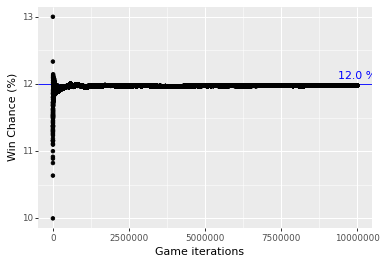

<ggplot: (8792569014528)>

In [3]:
from plotnine import *

ggplot(data, aes(x="iterations", y="win_percentage")) +\
    geom_hline(yintercept=12.0, color="blue") +\
    geom_point() +\
    geom_text(data[data["iterations"] == num_iterations], label="12.0 %", nudge_y=0.15, nudge_x=-3500, color="blue") +\
    xlab("Game iterations") +\
    ylab("Win Chance (%)")

In [4]:
win_percentage = list(data.iterrows())[-1][1]['win_percentage']

print(f"Chance of winning: ~{win_percentage}%")

Chance of winning: ~11.97607%


### # of tries to get >=90% chance to win

In [5]:
win_probability = win_percentage / 100.0

def chance_of_at_least_one_success(p, num_tries):
    return 1.0 - ((1.0 - p) ** num_tries)

print(chance_of_at_least_one_success(0.5, 1))
print(chance_of_at_least_one_success(0.5, 2))
print(chance_of_at_least_one_success(0.5, 3))
print(chance_of_at_least_one_success(0.5, 4))

0.5
0.75
0.875
0.9375


In [6]:
data2 = [
    (num_tries, chance_of_at_least_one_success(win_probability, num_tries) * 100.0)
    for num_tries in range(0, 31)
]

data2 = pd.DataFrame(data2, columns=["num_tries", "at_least_one_win_percentage"])
data2

,num_tries,at_least_one_win_percentage
0,0,0.000000
1,1,11.976070
2,2,22.517877
3,3,31.797191
4,4,39.965207
5,5,47.155016
6,6,53.483768
7,7,59.054585
8,8,63.958236
9,9,68.274623


/home/chris/anaconda3/envs/omori_pet_rocks/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/chris/anaconda3/envs/omori_pet_rocks/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plot.png


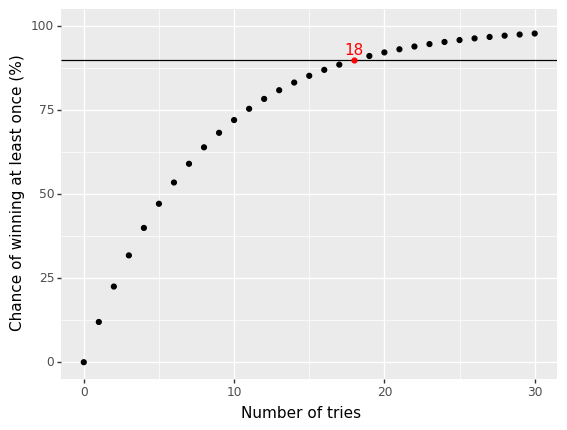

<ggplot: (8792566908433)>

In [7]:
import matplotlib.pyplot as plt

p = ggplot(data, aes(x="num_tries", y="at_least_one_win_percentage")) +\
    geom_point(data2[data2["num_tries"] != 18]) +\
    geom_hline(yintercept=90) +\
    geom_text(data2[data2["num_tries"] == 18], aes(label="num_tries"), nudge_y=3, color="red") +\
    geom_point(data2[data2["num_tries"] == 18], color="red") +\
    ylim(0.0, 100.0) +\
    xlab("Number of tries") +\
    ylab("Chance of winning at least once (%)")

ggsave(plot=p, filename='plot.png', dpi=100)
p